<a href="https://colab.research.google.com/github/ronald-hk-chung/ssnotebook/blob/main/computer_vision/dog_breed_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dog Breed Identification using Transfer Learning

In this workbook, we will try to use Transfer Learning on Kaggle Competition - Dog Breed Identification

## Overview

Who's a good dog? Who likes ear scratches? Well, it seems those fancy deep neural networks don't have all the answers. However, maybe they can answer that ubiquitous question we all ask when meeting a four-legged stranger: what kind of good pup is that?

In this playground competition, you are provided a strictly canine subset of ImageNet in order to practice fine-grained image categorization. How well you can tell your Norfolk Terriers from your Norwich Terriers? With 120 breeds of dogs and a limited number training images per class, you might find the problem more, err, ruff than you anticipated.

## Notebook Preperation

In [1]:
!pip install -q git+https://github.com/ronald-hk-chung/sstorch.git
!pip install -q kaggle
from sstorch.learner import SSTLearner
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torchinfo

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


## Downloading Kaggle Dataset

In [2]:
import shutil
from google.colab import files
files.upload() # upload kaggle.json
!ls -lha kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d carlosmiao/dogbreedidentification
!unzip -qq dogbreedidentification.zip

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 69 Jun 17 13:14 kaggle.json
Dataset URL: https://www.kaggle.com/datasets/carlosmiao/dogbreedidentification
License(s): unknown
100% 688M/691M [00:29<00:00, 28.1MB/s]
100% 691M/691M [00:29<00:00, 24.2MB/s]


## Investigate Data

In [3]:
# Investigate label.csv
df = pd.read_csv('labels.csv')
print(df.describe())
print(df.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     fff43b07992508bc822f33d8ffd902ae  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


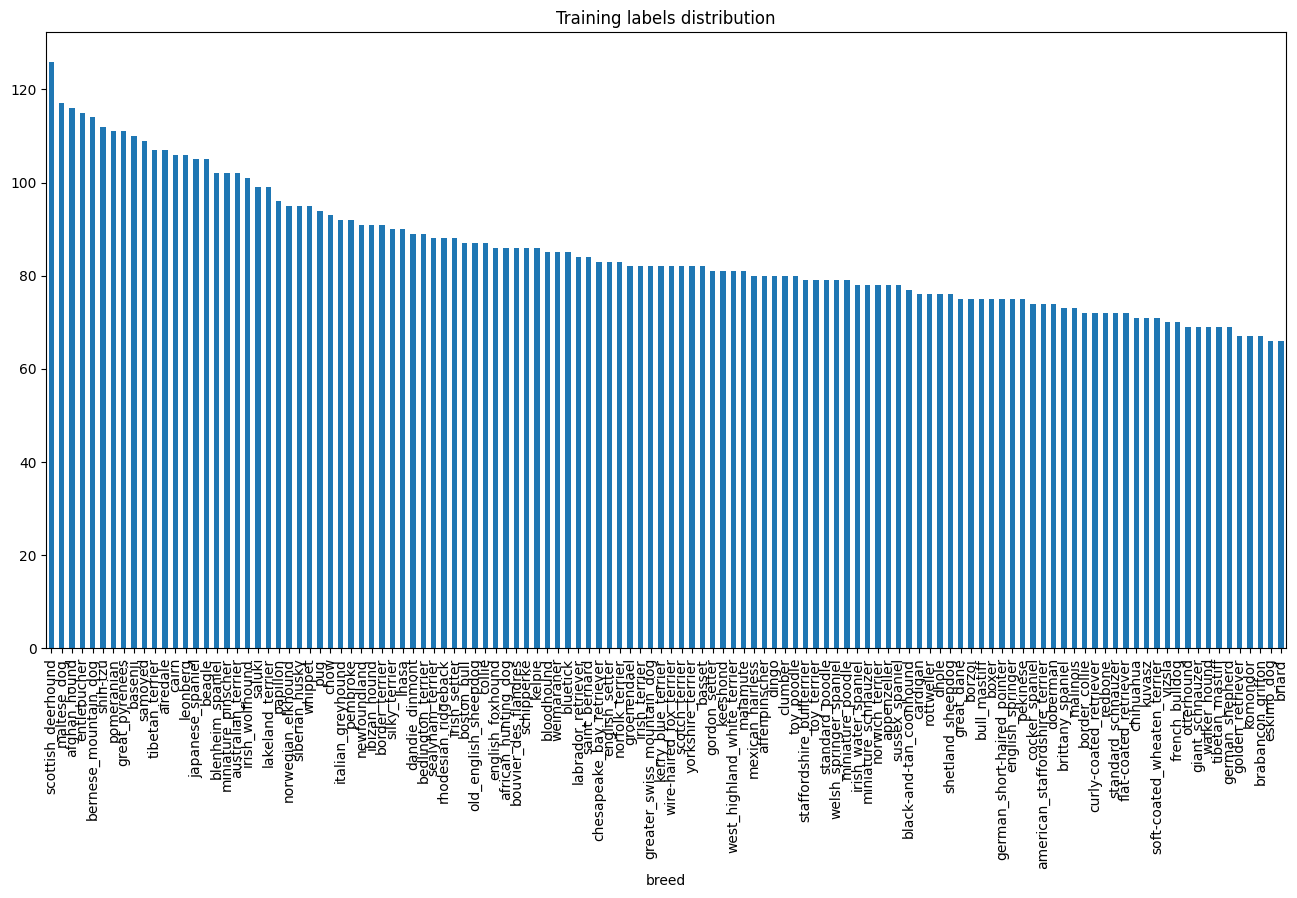

In [4]:
# Check out data distribution
df['breed'].value_counts().plot.bar(figsize=(16, 8));
plt.title('Training labels distribution');

In [5]:
unique_breeds = df.breed.unique()
idx_to_class = {idx: label for idx, label in enumerate(unique_breeds)}
class_to_idx = {label: idx for idx, label in enumerate(unique_breeds)}

In [6]:
# Prepare for training/valid dataset
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2 as T
from PIL import Image

# Train/Valid Split
df_train, df_valid = train_test_split(df, test_size=0.2)

# Get Resnet50 pretrained weights
weights = torchvision.models.get_weight("ResNet50_Weights.IMAGENET1K_V2")

# image transform for dataset
tfms = weights.transforms()

rtfms = T.Compose([
    T.Normalize(mean=[0.0] * 3,
                std = list(map(lambda x: 1/x, tfms.std))),
    T.Normalize(mean=list(map(lambda x: -x, tfms.mean)),
                std=[1.0] * 3),
    T.ToPILImage()
])

class DogBreedDataset(Dataset):
    def __init__(self, df, tfms):
        self.df = df
        self.tfms = tfms
        self.unique_breed = df.breed.unique()
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        path = f'train/{self.df.iloc[idx].id}.jpg'
        img = self.tfms(Image.open(path))
        label = torch.tensor(class_to_idx[self.df.iloc[idx].breed], dtype=torch.long)
        return img, label

In [7]:
train_ds = DogBreedDataset(df_train, tfms)
valid_ds = DogBreedDataset(df_valid, tfms)

train_dl = DataLoader(dataset=train_ds,
                      batch_size=32,
                      shuffle=True,
                      pin_memory=True,
                      drop_last=True)

valid_dl = DataLoader(dataset=valid_ds,
                      batch_size=32,
                      shuffle=False,
                      pin_memory=True,
                      drop_last=True)

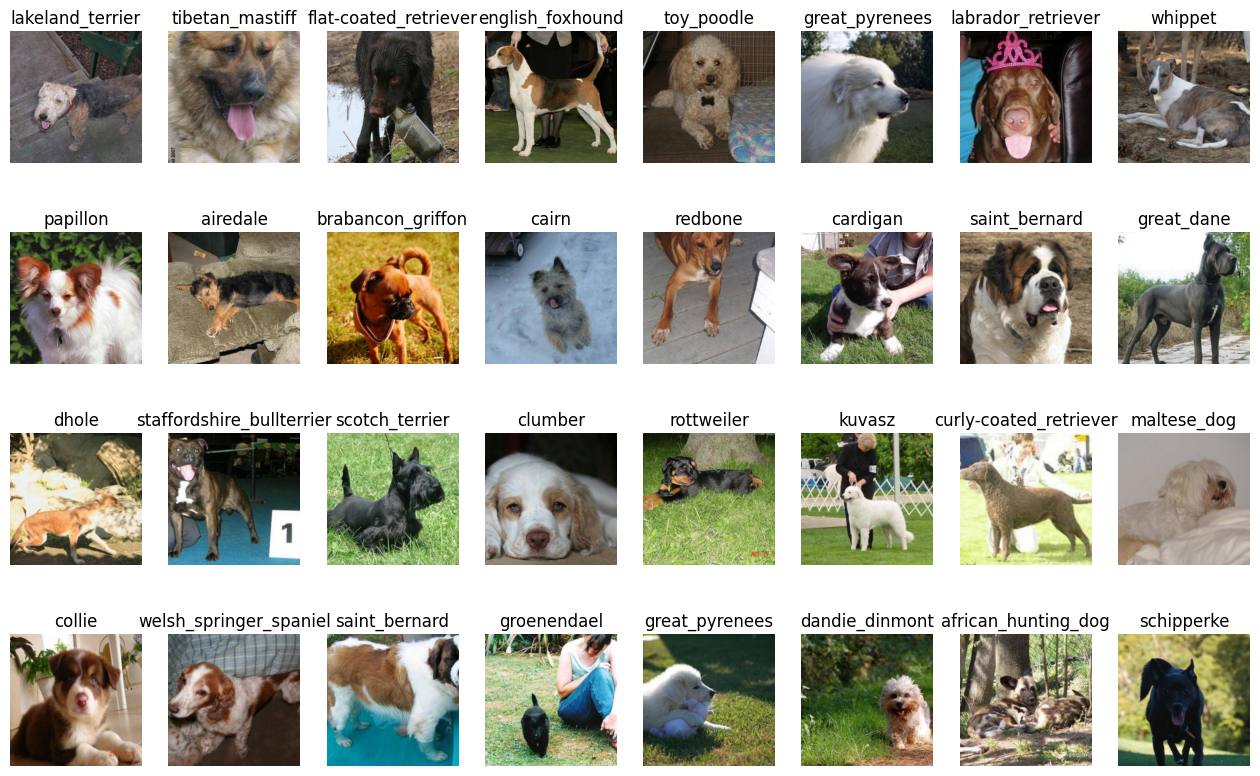

In [8]:
images, labels = next(iter(train_dl))

fig = plt.figure(figsize=(16, 10))
rows, columns = 4, 8
for i in range(len(labels)):
    plt.subplot(rows, columns, i+1)
    plt.imshow(rtfms(images[i]))
    plt.title(idx_to_class[labels[i].item()])
    plt.axis(False)

# Using Pre-trained model transfer learning

In [10]:
from torchvision.models import resnet50, ResNet50_Weights
model = resnet50(weights=ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 166MB/s]


In [11]:
import torch.nn as nn

model.fc = nn.Sequential(nn.Linear(2048, 1024),
                         nn.ReLU(),
                         nn.BatchNorm1d(1024),
                         nn.Dropout(0.2),
                         nn.Linear(1024, 512),
                         nn.ReLU(),
                         nn.BatchNorm1d(512),
                         nn.Dropout(0.2),
                         nn.Linear(512, 120))

In [12]:
import torch.nn as nn
from sklearn.metrics import accuracy_score, top_k_accuracy_score
from sstorch.vision.cifar100 import superclass_labels

# Define loss_fn
loss_fn = nn.CrossEntropyLoss()

# Define metric_fn that returns dictionary of accuracy, top_5_accuracy and accuracy_super
def metric_fn(y_logits, y):
    # Get Probs and Probabilities using softmax and argmax
    y_probs = y_logits.softmax(dim=-1).detach().cpu().numpy()
    y_preds = y_probs.argmax(axis=-1)
    y = y.detach().cpu().numpy()

    accuracy = accuracy_score(y, y_preds)
    return {'accuracy': accuracy}

# Define optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=1e-3)

learner = SSTLearner(model=model,
                     loss_fn=loss_fn,
                     metric_fn=metric_fn,
                     optimizer=optimizer,
                     train_dataloader=train_dl,
                     valid_dataloader=valid_dl)


In [13]:
learner.model_info()

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 3, 224, 224]    [32, 120]            --                   True
├─Conv2d (conv1)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
├─BatchNorm2d (bn1)                      [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
├─ReLU (relu)                            [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
├─MaxPool2d (maxpool)                    [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
├─Sequential (layer1)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    └─Bottleneck (0)                    [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─Conv2d (conv1)               [32, 64, 56, 56]     [32, 64, 56, 56]     4,096                True
│    │    └─BatchN

In [14]:
learner.freeze()
learner.unfreeze(['fc'])

  0%|          | 0/100 [00:00<?, ?it/s]

Max Gradient: 1.74E-03 | Lowest Loss: 2.09E-02


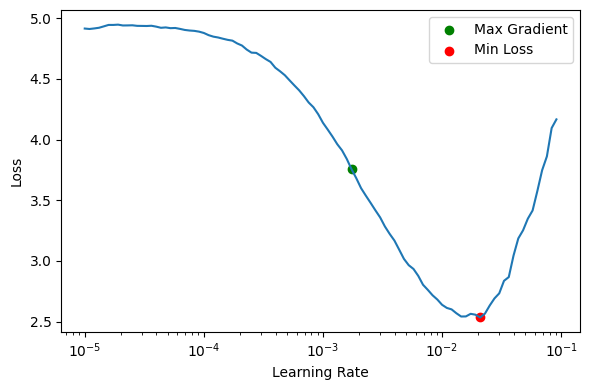

In [15]:
learner.lr_range_test(end_lr=1e-1, start_lr=1e-5)

In [16]:
learner.train(5)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | LR: 1.0E-03 | train_loss: 1.383 | valid_loss: 0.642 
train_metric: {'accuracy': 0.656}
valid_metric: {'accuracy': 0.802}
----------------------------------------------------------------------------------------------------
Epoch: 2 | LR: 1.0E-03 | train_loss: 0.558 | valid_loss: 0.678 
train_metric: {'accuracy': 0.831}
valid_metric: {'accuracy': 0.795}
----------------------------------------------------------------------------------------------------
Epoch: 3 | LR: 1.0E-03 | train_loss: 0.407 | valid_loss: 0.665 
train_metric: {'accuracy': 0.871}
valid_metric: {'accuracy': 0.813}
----------------------------------------------------------------------------------------------------
Epoch: 4 | LR: 1.0E-03 | train_loss: 0.313 | valid_loss: 0.636 
train_metric: {'accuracy': 0.903}
valid_metric: {'accuracy': 0.828}
----------------------------------------------------------------------------------------------------
Epoch: 5 | LR: 1.0E-03 | train_loss: 0.241 | valid_loss: 0.708 
trai

## Make Prediction

In [58]:
import requests
from torch.nn.functional import softmax
from PIL import Image

image_url = 'https://lh3.googleusercontent.com/pw/ADCreHevLcbbqHt0oFdshpwtqnYzw77BtSWzKt_wOArFJxcSKeKZAdLCFX9YSD8yIuPwVhGISXAmgvmR0I9TC-kotIKbb-TAW7khuxfVyLSH2BSElhrzfnMZ=w2400'
im = Image.open(requests.get(url=image_url, stream=True).raw).convert('RGB')
with torch.inference_mode():
    y_logits = model(tfms(im).unsqueeze(0).to('cuda'))
    y_probs = softmax(y_logits, 1).squeeze(0)
    y_pred = y_logits.argmax(1).item()

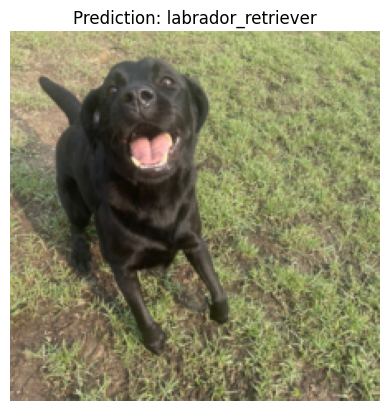

In [61]:
plt.imshow(rtfms(tfms(im)))
plt.title(f'Prediction: {idx_to_class[y_pred]}')
plt.axis(False);